In [1]:
import numpy as np
from pathlib import Path
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from models import muq, RoBERTa, word2vec
import librosa
import soundfile as sf
import torch
from main import *
import tqdm

SAMPLING_RATE = 44100


c:\Users\dzluk\.conda\envs\QE\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
parameters = {
        "sound_corpus_path": "./corpora/sound/toy",
        "text_corpus_path": "./corpora/text/repeat.txt",
        "sound_encoder": "MuQ",
        "text_encoder": "word2vec",
        "output_path": "./output",
        "grain_size":3000,  # in ms
        "distance": "euclidean",
        "trim_silence": True,
}

# a function that determines how to separate sounds
grain_size = int(parameters['grain_size'] / 1000.0 * SAMPLING_RATE)  # convert to samples
slice_fn = lambda y: equal_slices(y, grain_size)

sound_corpus_path = Path(parameters["sound_corpus_path"])
text_corpus_path = Path(parameters["text_corpus_path"])

if parameters["sound_encoder"] == "MuQ":
    sound_encoder = muq
if parameters["text_encoder"] == "RoBERTa":
    text_encoder = RoBERTa
elif parameters["text_encoder"] == "word2vec":
    text_encoder = word2vec

print("Loading sound and text data...")
sound_corpus = load_soundfiles(sound_corpus_path)
sound_corpus = preprocess_sounds(sound_corpus, slice_fn, parameters["trim_silence"])

text_corpus = load_text_corpus(text_corpus_path)

print("Embedding sounds...")
sound_embeddings = embed_sounds(sound_corpus, sound_encoder)

print("Embedding text...")

text_embeddings = embed_text(" ".join(text_corpus), text_encoder)

Loading sound and text data...
Embedding sounds...
MuQ: feature shape:  torch.Size([1, 11, 1024])
MuQ: feature shape:  torch.Size([1, 8, 1024])
MuQ: feature shape:  torch.Size([1, 75, 1024])
MuQ: feature shape:  torch.Size([1, 75, 1024])
MuQ: feature shape:  torch.Size([1, 75, 1024])
MuQ: feature shape:  torch.Size([1, 75, 1024])
MuQ: feature shape:  torch.Size([1, 75, 1024])
MuQ: feature shape:  torch.Size([1, 75, 1024])
MuQ: feature shape:  torch.Size([1, 75, 1024])
Embedding text...
word2vec shape:  (8, 300)


In [10]:
normalization = StandardScaler()
dim = 2  # the number of dimensions to reduce to
mapping = 'cluster'

print("Transforming embeddings...")
# what transformations will we apply to the feature space?
transform_pipeline = create_pipeline(normalization, dim)
for transform in transform_pipeline:
    sound_embeddings = transform(sound_embeddings)
    text_embeddings = transform(text_embeddings)

print(f"Mapping text to sound with method {mapping}...")
# mapping options: identity, cluster_map
if mapping == "identity":
    mapping_fn = identity
elif mapping == "cluster":
    mapping_fn = cluster_map
else:
    raise Exception("Invalid mapping provided")

neighbor_indices = mapping_fn(sound_embeddings, text_embeddings, parameters['distance'])

print("Fetching sounds...")
output_sounds = [sound_corpus[i] for i in neighbor_indices]

print("Saving output...")
save_output(output_sounds, Path(parameters["output_path"]))

print("Done.")

Transforming embeddings...
Mapping text to sound with method cluster...
Applying clustering...
Sound silhouette_score (higher is better): 0.7728553387361954
Sound calinski_harabasz_score (higher is better): 23.44798768205515
Sound davies_bouldin_score (lower is better): 0.5096284971757367


Text silhouette_score (higher is better): 1.0
Text calinski_harabasz_score (higher is better): 2.3330019820599845e+32
Text davies_bouldin_score (lower is better): 0.0
Fetching sounds...
Saving output...
Done.


C:\Users\dzluk\.conda\envs\QE\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dzluk\.conda\envs\QE\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


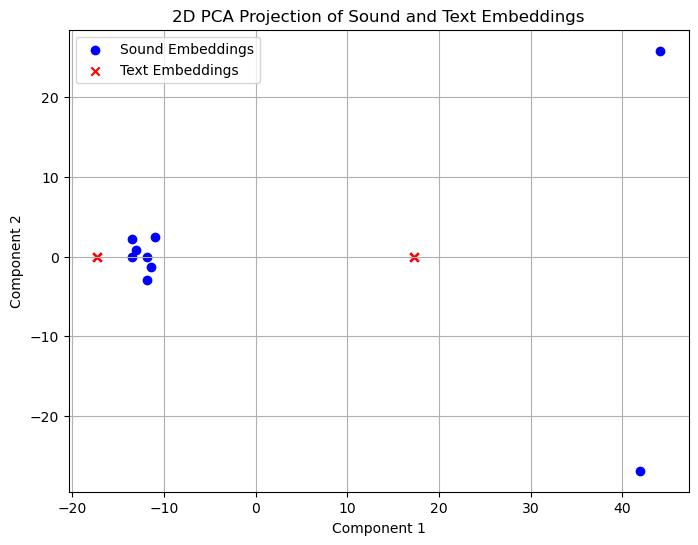

In [11]:
import matplotlib.pyplot as plt

def plot_2d_embeddings(sound_embeddings, text_embeddings):
    plt.figure(figsize=(8, 6))

    # Plot sound embeddings (in blue)
    plt.scatter(sound_embeddings[:, 0], sound_embeddings[:, 1], color='blue', marker='o', label='Sound Embeddings', alpha=1)

    # Plot text embeddings (in red)
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings', alpha=1)

    # Add labels and legend
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection of Sound and Text Embeddings')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_2d_embeddings(sound_embeddings, text_embeddings)

C:\Users\dzluk\AppData\Local\Temp\ipykernel_9000\2129851642.py:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(highlighted_text[0], highlighted_text[1], color='red', marker='x', s=100, edgecolors='black', label='Input Text', zorder=5)


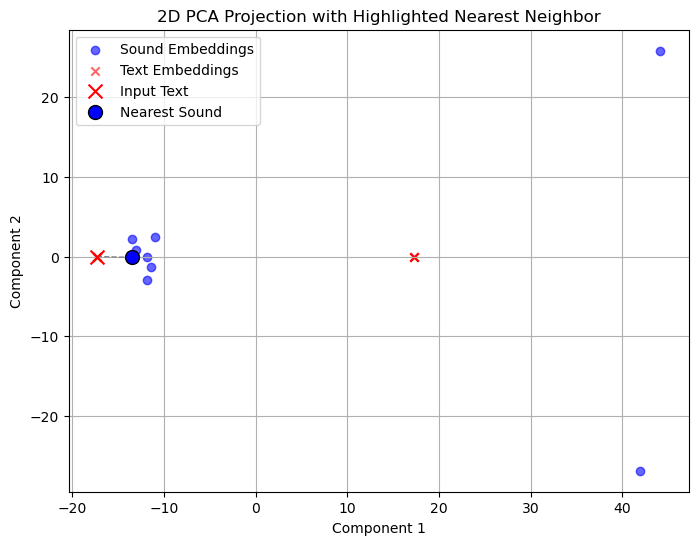

In [15]:
def plot_2d_embeddings_with_highlight(sound_embeddings, text_embeddings, highlighted_text_idx, nearest_sound_idx):
    plt.figure(figsize=(8, 6))

    # Plot all sound embeddings (in blue)
    plt.scatter(sound_embeddings[:, 0], sound_embeddings[:, 1], color='blue', label='Sound Embeddings', alpha=0.6)

    # Plot all text embeddings (in red)
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings', alpha=0.6)

    # Highlight the specific text embedding (in green)
    highlighted_text = text_embeddings[highlighted_text_idx]
    plt.scatter(highlighted_text[0], highlighted_text[1], color='red', marker='x', s=100, edgecolors='black', label='Input Text', zorder=5)

    # Highlight the nearest neighbor sound embedding (in purple)
    nearest_sound = sound_embeddings[nearest_sound_idx]
    plt.scatter(nearest_sound[0], nearest_sound[1], color='blue', s=100, edgecolors='black', label='Nearest Sound', zorder=5)

    # Draw an arrow or line between the points
    plt.plot([highlighted_text[0], nearest_sound[0]],
             [highlighted_text[1], nearest_sound[1]],
             color='gray', linestyle='--', linewidth=1)

    # Add labels and legend
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection with Highlighted Nearest Neighbor')
    plt.legend()
    plt.grid(True)
    plt.show()

i = 2
plot_2d_embeddings_with_highlight(sound_embeddings, text_embeddings, i, neighbor_indices[i])

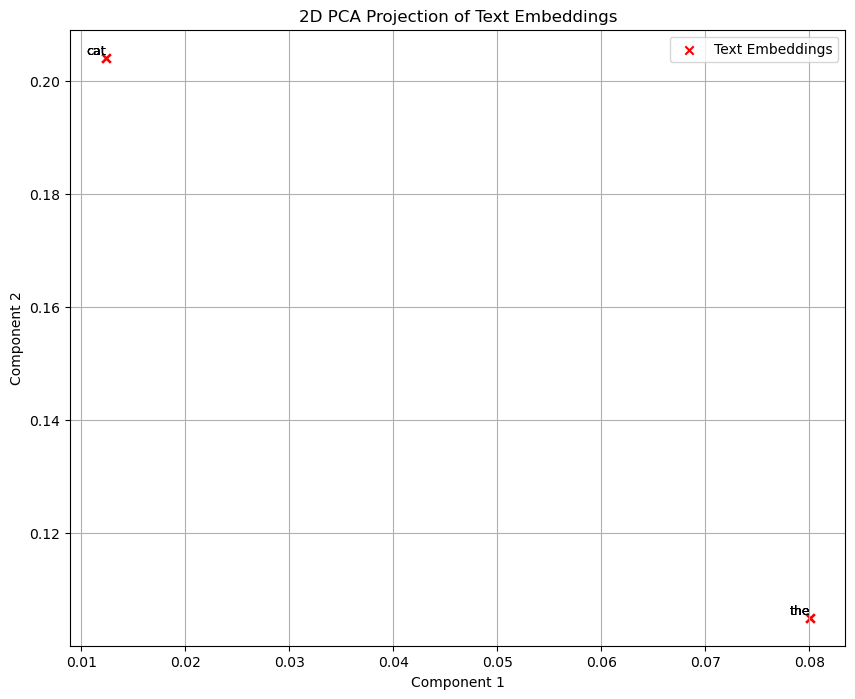

In [9]:
def plot_text_embeddings_with_labels(text_embeddings, text_corpus):
    assert text_embeddings.shape[0] == len(text_corpus)
    plt.figure(figsize=(10, 8))

    # Plot text embeddings with red 'x' markers
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings')

    # Add labels to each point
    for i, word in enumerate(text_corpus):
        plt.text(text_embeddings[i, 0], text_embeddings[i, 1], word, fontsize=9, ha='right', va='bottom')

    # Formatting
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection of Text Embeddings')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_text_embeddings_with_labels(text_embeddings, text_corpus)

Sound Cluster centers: [[-12.29283056   0.14993852]
 [ 43.02490697  -0.52478482]]
Sound Labels: [1 1 0 0 0 0 0 0 0]
Text Cluster centers: [[ 1.73205081e+01  4.83820579e-16]
 [-1.73205081e+01  4.83820579e-16]]
Text Labels: [1 0 1 0 1 0 1 0]


C:\Users\dzluk\.conda\envs\QE\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dzluk\.conda\envs\QE\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

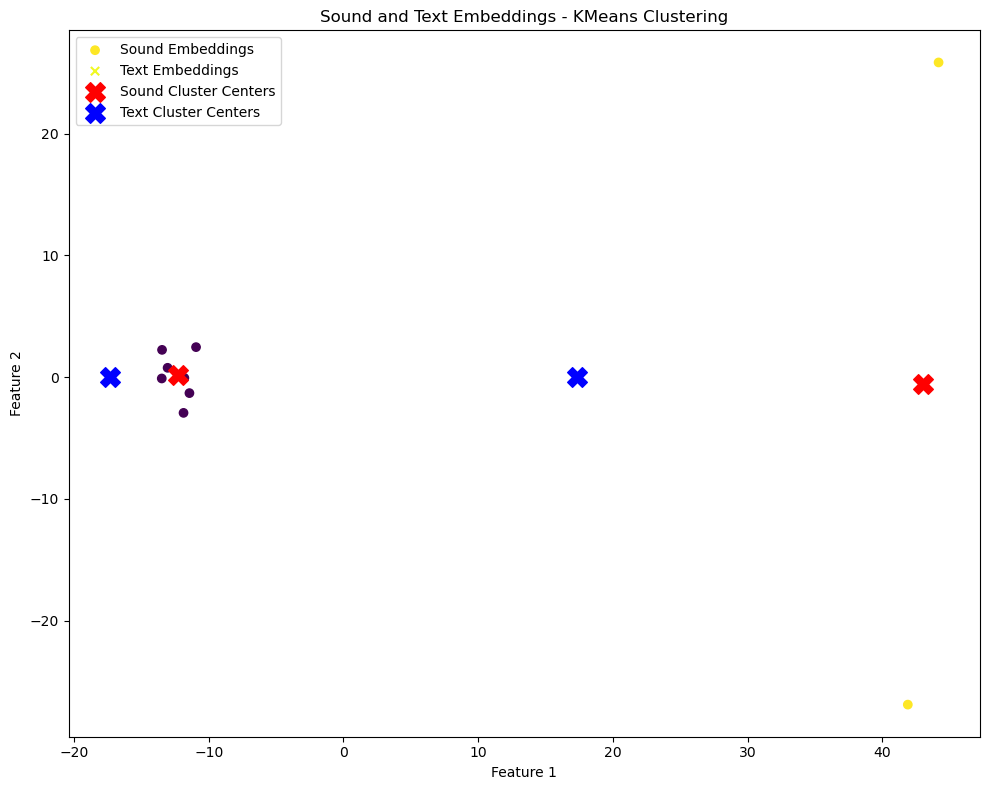

In [16]:
from sklearn.cluster import KMeans

k = 2
kmeans_sound = KMeans(n_clusters=k, n_init=10).fit(sound_embeddings)
kmeans_text = KMeans(n_clusters=k, n_init=10).fit(text_embeddings)

# Results
print("Sound Cluster centers:", kmeans_sound.cluster_centers_)
print("Sound Labels:", kmeans_sound.labels_)
print("Text Cluster centers:", kmeans_text.cluster_centers_)
print("Text Labels:", kmeans_text.labels_)

plt.figure(figsize=(12, 6))

# Visualizing Sound and Text Clusters on the Same Plot
plt.figure(figsize=(10, 8))

# Plot sound embeddings
plt.scatter(sound_embeddings[:, 0], sound_embeddings[:, 1], c=kmeans_sound.labels_, cmap='viridis', marker='o', label='Sound Embeddings')

# Plot text embeddings
plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], c=kmeans_text.labels_, cmap='plasma', marker='x', label='Text Embeddings')

# Plot cluster centers
plt.scatter(kmeans_sound.cluster_centers_[:, 0], kmeans_sound.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Sound Cluster Centers')
plt.scatter(kmeans_text.cluster_centers_[:, 0], kmeans_text.cluster_centers_[:, 1], s=200, c='blue', marker='X', label='Text Cluster Centers')

# Labels and title
plt.title("Sound and Text Embeddings - KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
sound_kmeans.labels_

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0], dtype=int32)

c:\Users\dzluk\.conda\envs\QE\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running ICP with max_iterations=50, batch_size=32, cycle_weight=0.1, learning_rate=0.01
Applying ICP mapping with 50 iterations...
Iteration 0: Validation Loss = 2.5342
Iteration 10: Validation Loss = 4.5331
Iteration 20: Validation Loss = 4.4961
Iteration 30: Validation Loss = 4.5167
Iteration 40: Validation Loss = 4.4243
Iteration 49: Validation Loss = 4.3951


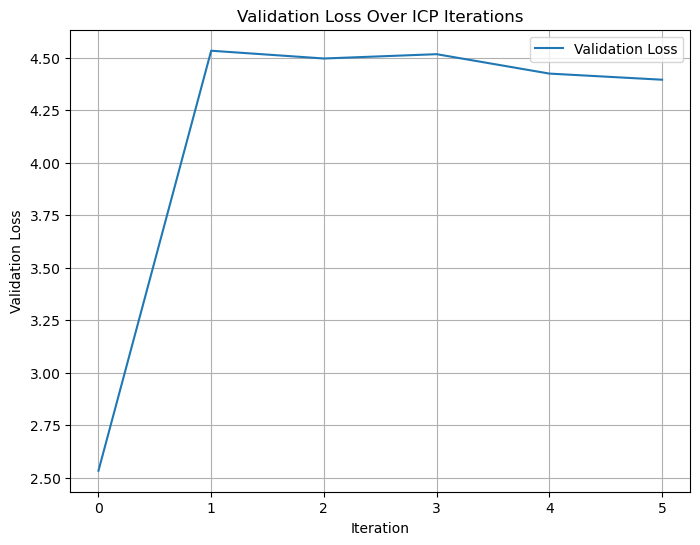

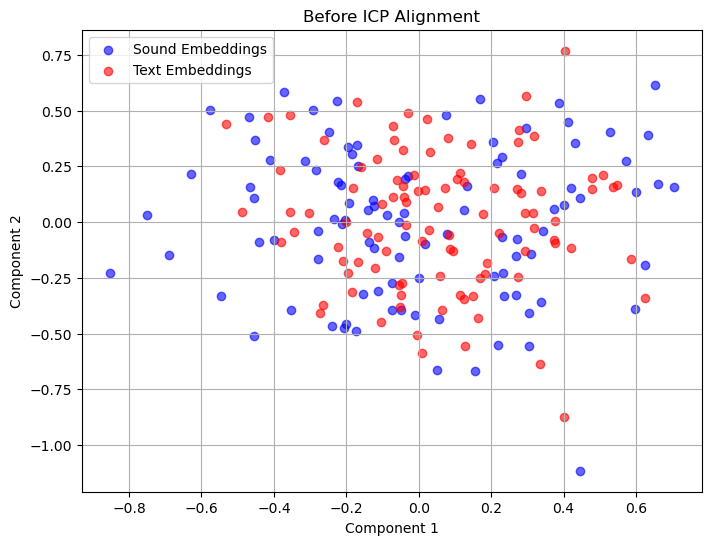

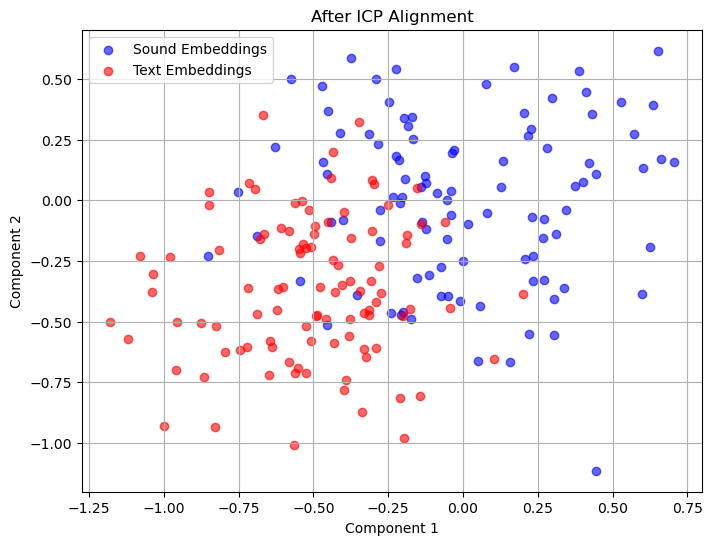

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from main import icp_map, identity, cluster_map

# Function to run ICP and visualize results
def test_icp(
    sound_embeddings,
    text_embeddings,
    distance_metric="euclidean",
    max_iterations=50,
    batch_size=32,
    cycle_weight=0.1,
    learning_rate=0.01,
    plot=True,
):
    """
    Test and debug the ICP algorithm with different hyperparameters.

    Args:
        sound_embeddings (np.ndarray): Sound embeddings.
        text_embeddings (np.ndarray): Text embeddings.
        distance_metric (str): Distance metric to use ("euclidean" or "cosine").
        max_iterations (int): Maximum number of ICP iterations.
        batch_size (int): Batch size for mini-batch optimization.
        cycle_weight (float): Weight for the cycle consistency loss.
        learning_rate (float): Learning rate for gradient updates.
        plot (bool): Whether to plot the embeddings before and after alignment.

    Returns:
        np.ndarray: Transformed text embeddings after ICP.
        list: Validation loss over iterations.
    """
    print(f"Running ICP with max_iterations={max_iterations}, batch_size={batch_size}, cycle_weight={cycle_weight}, learning_rate={learning_rate}")
    
    # Run ICP
    transformed_text_embeddings, validation_losses = icp_map(
        sound_embeddings,
        text_embeddings,
        distance_metric=distance_metric,
        max_iterations=max_iterations,
        batch_size=batch_size,
        cycle_weight=cycle_weight,
        learning_rate=learning_rate,
        return_validation_loss=True,  # Ensure validation loss is returned
    )
    
    # Plot validation loss over iterations
    plt.figure(figsize=(8, 6))
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss Over ICP Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot embeddings before and after alignment
    if plot:
        plot_2d_embeddings(sound_embeddings, text_embeddings, title="Before ICP Alignment")
        plot_2d_embeddings(sound_embeddings, transformed_text_embeddings, title="After ICP Alignment")
    
    return transformed_text_embeddings, validation_losses

# Function to plot embeddings
def plot_2d_embeddings(embeddings1, embeddings2, title="Embeddings"):
    """
    Plot two sets of embeddings in 2D space.

    Args:
        embeddings1 (np.ndarray): First set of embeddings (e.g., sound).
        embeddings2 (np.ndarray): Second set of embeddings (e.g., text).
        title (str): Title of the plot.
    """
    # Reduce dimensionality to 2D using PCA if necessary
    if embeddings1.shape[1] > 2:
        pca = PCA(n_components=2)
        embeddings1 = pca.fit_transform(embeddings1)
        embeddings2 = pca.transform(embeddings2)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings1[:, 0], embeddings1[:, 1], color="blue", label="Sound Embeddings", alpha=0.6)
    plt.scatter(embeddings2[:, 0], embeddings2[:, 1], color="red", label="Text Embeddings", alpha=0.6)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Test ICP with different hyperparameters
sound_embeddings = np.random.rand(100, 10)  # Replace with actual sound embeddings
text_embeddings = np.random.rand(100, 10)  # Replace with actual text embeddings

# Test ICP
transformed_text_embeddings, validation_losses = test_icp(
    sound_embeddings,
    text_embeddings,
    distance_metric="euclidean",
    max_iterations=50,
    batch_size=32,
    cycle_weight=0.1,
    learning_rate=0.01,
    plot=True,
)

Loading sound and text data...
Embedding sounds...
Loading sound embeddings from cache: cache\sound_toy_full_MuQ.pkl
Embedding text...
Loading text embeddings from cache: cache\text_repeat.txt_fastText.pkl
Transforming embeddings...
Running ICP with max_iterations=50, batch_size=32, cycle_weight=0.1, learning_rate=0.01
Applying ICP mapping with 50 iterations...
Iteration 0: Validation Loss = 84.3380
Iteration 10: Validation Loss = 76.5344
Iteration 20: Validation Loss = 80.0378
Iteration 30: Validation Loss = 64.7153
Iteration 40: Validation Loss = 88.3460
Iteration 49: Validation Loss = 66.7121


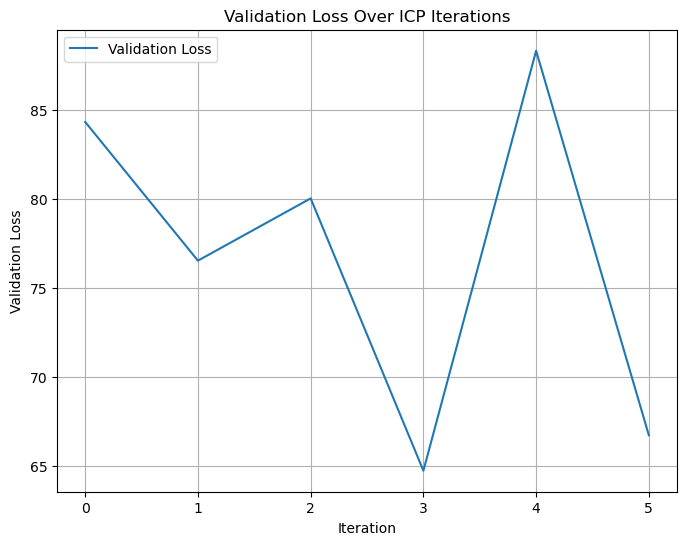

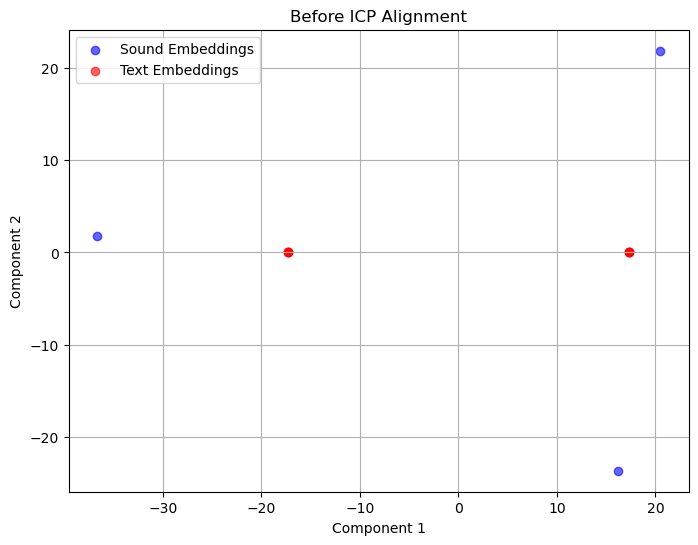

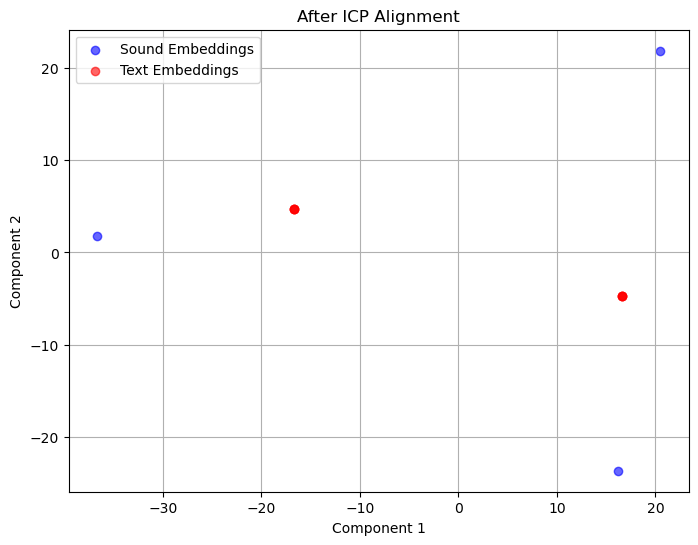

In [10]:
from util import Parameter
from pathlib import Path
def run(params, cache=True):
    sound_corpus_path = Path(params.sound_path)
    text_corpus_path = Path(params.text_path)

    if params.sound_encoder == "MuQ":
        sound_encoder = muq

    if params.text_encoder == "RoBERTa":
        text_encoder = RoBERTa
    elif params.text_encoder == "word2vec":
        text_encoder = word2vec
    elif params.text_encoder == "fastText":
        text_encoder = fastText

    print("Loading sound and text data...")
    sound_corpus = load_soundfiles(sound_corpus_path)
    text_corpus = load_text_corpus(text_corpus_path)

    # check to see if this will be a valid run
    if params.dim > len(sound_corpus) or params.dim > len(text_corpus):
        print(f"!!!: Input PCA dimension {params.dim} cannot be larger than length of sound corpus ({len(sound_corpus)}) or text corpus ({len(text_corpus)})")
        print("Ending this run.")
        return None

    # slice_fn: a function that determines how to separate sounds
    try:
        grain_size = int(params.sound_preprocessing / 1000.0 * SAMPLING_RATE)
        slice_fn = lambda y: equal_slices(y, grain_size)
        slice_fn_name = f"grain{params.sound_preprocessing}"
    except TypeError:
        if params.sound_preprocessing == "onsets":
            slice_fn = lambda y: get_onsets(y)
            slice_fn_name = "onsets"
        elif params.sound_preprocessing == "full":
            # slice_fn = lambda y: y
            slice_fn_name = "full"
        else:
            raise ValueError(f"Unknown preprocessing {params.sound_preprocessing}")
    if params.sound_preprocessing != 'full':
        sound_corpus = preprocess_sounds(sound_corpus, slice_fn, params.trim_silence)

    if params.sound_encoder == "MuQ":
        sound_corpus = [s for s in sound_corpus if s.size > 1024]  # MuQ requires sounds longer than 1024 samples

    sound_cache_file = None
    text_cache_file = None
    if cache:
        # Generate cache file paths
        sound_cache_file = generate_sound_cache_filename(
            corpus_name=sound_corpus_path.stem,
            slice_fn_name=slice_fn_name,
            encoder_name=params.sound_encoder,
        )
        text_cache_file = generate_text_cache_filename(
            text_file_name=text_corpus_path.name,
            encoder_name=params.text_encoder,
        )

    print("Embedding sounds...")
    sound_embeddings = embed_sounds(sound_corpus, sound_encoder, sound_cache_file)

    print("Embedding text...")
    text_embeddings = embed_text(" ".join(text_corpus), text_encoder, text_cache_file)

    # check again to see if this will be a valid run
    if params.dim > len(sound_embeddings) or params.dim > len(text_embeddings):
        print(
            f"!!!: Input PCA dimension {params.dim} cannot be larger than length of sound embeds ({len(sound_embeddings)}) or text embeds ({len(text_embeddings)})")
        print("Ending this run.")
        return None

    print("Transforming embeddings...")
    # what transformations will we apply to the feature space?
    if params.normalization == "standard":
        norm_method = StandardScaler()
    else:
        raise KeyError("Unknown normalization method")

    transform_pipeline = create_pipeline(norm_method, params.dim)
    for transform in transform_pipeline:
        sound_embeddings = transform(sound_embeddings)
        text_embeddings = transform(text_embeddings)

    # Test ICP
    transformed_text_embeddings, validation_losses = test_icp(
        sound_embeddings,
        text_embeddings,
        distance_metric="euclidean",
        max_iterations=50,
        batch_size=32,
        cycle_weight=0.1,
        learning_rate=0.01,
        plot=True,
    )

p=Parameter(
    sound_path="./corpora/sound/toy",
    text_path="./corpora/text/repeat.txt",
    sound_encoder="MuQ",
    text_encoder="fastText",
    sound_preprocessing='full',  # in ms
    dim=2,
    mapping='icp',
    distance_metric="euclidean",
    trim_silence=True,
    normalization="standard"
)
run(p)

In [1]:
import pandas as pd

# Filepath to the evaluation results CSV
file_path = "./evaluation_results/evaluation_results.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Separate experiments based on the distance metric
euclidean_experiments = df[df["distance_metric"] == "euclidean"]
cosine_experiments = df[df["distance_metric"] == "cosine"]

# Function to compute statistics for a given column
def compute_stats(group, column_name):
    avg = group[column_name].mean()
    std = group[column_name].std()
    min_val = group[column_name].min()
    max_val = group[column_name].max()
    return avg, std, min_val, max_val

# Compute statistics for pairwise_distance and wasserstein_distance
metrics = ["pairwise_distance", "wasserstein_distance"]

print("Statistics for Euclidean Distance Metric:")
for metric in metrics:
    avg, std, min_val, max_val = compute_stats(euclidean_experiments, metric)
    print(f"  {metric}:")
    print(f"    Average: {avg:.4f}, Standard Deviation: {std:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")

print("\nStatistics for Cosine Distance Metric:")
for metric in metrics:
    avg, std, min_val, max_val = compute_stats(cosine_experiments, metric)
    print(f"  {metric}:")
    print(f"    Average: {avg:.4f}, Standard Deviation: {std:.4f}, Min: {min_val:.4f}, Max: {max_val:.4f}")

Statistics for Euclidean Distance Metric:
  pairwise_distance:
    Average: 5.1385, Standard Deviation: 3.1101, Min: 0.0218, Max: 17.9284
  wasserstein_distance:
    Average: 3.4018, Standard Deviation: 2.5672, Min: 0.0218, Max: 15.4422

Statistics for Cosine Distance Metric:
  pairwise_distance:
    Average: 0.1864, Standard Deviation: 0.1069, Min: 0.0000, Max: 0.5806
  wasserstein_distance:
    Average: 0.0741, Standard Deviation: 0.0656, Min: 0.0000, Max: 0.5296


# ICP Hyperparameter Tuning

In [13]:
import numpy as np
from itertools import product
from scipy.stats import pearsonr


def load_and_process(params):
    cache = True
    sound_corpus_path = Path(params.sound_path)
    text_corpus_path = Path(params.text_path)

    if params.sound_encoder == "MuQ":
        sound_encoder = muq

    if params.text_encoder == "RoBERTa":
        text_encoder = RoBERTa
    elif params.text_encoder == "word2vec":
        text_encoder = word2vec
    elif params.text_encoder == "fastText":
        text_encoder = fastText

    print("Loading sound and text data...")
    sound_corpus = load_soundfiles(sound_corpus_path)
    text_corpus = load_text_corpus(text_corpus_path)

    # check to see if this will be a valid run
    if params.dim > len(sound_corpus) or params.dim > len(text_corpus):
        print(f"!!!: Input PCA dimension {params.dim} cannot be larger than length of sound corpus ({len(sound_corpus)}) or text corpus ({len(text_corpus)})")
        print("Ending this run.")
        return None

    # slice_fn: a function that determines how to separate sounds
    try:
        grain_size = int(params.sound_preprocessing / 1000.0 * SAMPLING_RATE)
        slice_fn = lambda y: equal_slices(y, grain_size)
        slice_fn_name = f"grain{params.sound_preprocessing}"
    except TypeError:
        if params.sound_preprocessing == "onsets":
            slice_fn = lambda y: get_onsets(y)
            slice_fn_name = "onsets"
        elif params.sound_preprocessing == "full":
            # slice_fn = lambda y: y
            slice_fn_name = "full"
        else:
            raise ValueError(f"Unknown preprocessing {params.sound_preprocessing}")
    if params.sound_preprocessing != 'full':
        sound_corpus = preprocess_sounds(sound_corpus, slice_fn, params.trim_silence)

    if params.sound_encoder == "MuQ":
        sound_corpus = [s for s in sound_corpus if s.size > 1024]  # MuQ requires sounds longer than 1024 samples

    sound_cache_file = None
    text_cache_file = None
    if cache:
        # Generate cache file paths
        sound_cache_file = generate_sound_cache_filename(
            corpus_name=sound_corpus_path.stem,
            slice_fn_name=slice_fn_name,
            encoder_name=params.sound_encoder,
        )
        text_cache_file = generate_text_cache_filename(
            text_file_name=text_corpus_path.name,
            encoder_name=params.text_encoder,
        )

    print("Embedding sounds...")
    sound_embeddings = embed_sounds(sound_corpus, sound_encoder, sound_cache_file)

    print("Embedding text...")
    text_embeddings = embed_text(" ".join(text_corpus), text_encoder, text_cache_file)

    # check again to see if this will be a valid run
    if params.dim > len(sound_embeddings) or params.dim > len(text_embeddings):
        print(
            f"!!!: Input PCA dimension {params.dim} cannot be larger than length of sound embeds ({len(sound_embeddings)}) or text embeds ({len(text_embeddings)})")
        print("Ending this run.")
        return None

    print("Transforming embeddings...")
    # what transformations will we apply to the feature space?
    if params.normalization == "standard":
        norm_method = StandardScaler()
    else:
        raise KeyError("Unknown normalization method")

    transform_pipeline = create_pipeline(norm_method, params.dim)
    for transform in transform_pipeline:
        sound_embeddings = transform(sound_embeddings)
        text_embeddings = transform(text_embeddings)

    return sound_embeddings, text_embeddings


def tune_icp_parameters(sound_embeddings, text_embeddings, hyperparameter_space):
    """
    Tune ICP parameters by running experiments with different combinations of hyperparameters.
    Also calculate pairwise_distance and analyze its relationship with validation loss.
    """
    # Generate all combinations of hyperparameters
    hyperparameter_combinations = list(product(
        hyperparameter_space["learning_rate"],
        hyperparameter_space["batch_size"],
        hyperparameter_space["cycle_weight"],
        hyperparameter_space["max_iterations"]
    ))

    # Placeholder for the best hyperparameters and lowest validation loss
    best_hyperparameters = None
    highest_percentage_decrease = float("-inf")
    lowest_pairwise_distance = float("inf")
    best_pairwise_hyperparameters = None

    # Store results for analysis
    results = []

    # Distance metric
    distance_metric = "euclidean"  # Use "cosine" if needed

    # Iterate over all hyperparameter combinations
    for learning_rate, batch_size, cycle_weight, max_iterations in hyperparameter_combinations:
        print(f"Testing hyperparameters: lr={learning_rate}, batch_size={batch_size}, cycle_weight={cycle_weight}, max_iterations={max_iterations}")
        
        # Run ICP with the current hyperparameters
        neighbor_indices, validation_losses = icp_map(
            sound_embeddings=sound_embeddings,
            text_embeddings=text_embeddings,
            distance_metric=distance_metric,
            max_iterations=max_iterations,
            batch_size=batch_size,
            cycle_weight=cycle_weight,
            learning_rate=learning_rate,
            return_validation_loss=True
        )

        # Calculate validation loss changes
        initial_loss = validation_losses[0]
        final_loss = validation_losses[-1]
        absolute_decrease = initial_loss - final_loss
        percentage_decrease = (absolute_decrease / initial_loss) * 100 if initial_loss != 0 else 0

        print(f"Initial loss: {initial_loss:.4f}")
        print(f"Final loss: {final_loss:.4f}")
        print(f"Absolute decrease: {absolute_decrease:.4f}")
        print(f"Percentage decrease: {percentage_decrease:.2f}%")

        # Calculate pairwise distance
        pairwise_dist = pairwise_distance(text_embeddings, sound_embeddings[neighbor_indices], lambda x, y: np.linalg.norm(x - y))
        print(f"Pairwise distance: {pairwise_dist}")

        # Store results
        results.append((
            learning_rate, 
            batch_size, 
            cycle_weight, 
            max_iterations, 
            initial_loss,
            final_loss, 
            absolute_decrease,
            percentage_decrease,
            pairwise_dist
        ))

        # Track best hyperparameters by percentage decrease
        if percentage_decrease > highest_percentage_decrease:
            highest_percentage_decrease = percentage_decrease
            best_hyperparameters = {
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "cycle_weight": cycle_weight,
                "max_iterations": max_iterations
            }
        # Update the best hyperparameters for pairwise distance
        if pairwise_dist < lowest_pairwise_distance:
            lowest_pairwise_distance = pairwise_dist
            best_pairwise_hyperparameters = {
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "cycle_weight": cycle_weight,
                "max_iterations": max_iterations
            }

    # Analyze the relationship between validation loss and pairwise distance
    validation_losses = [result[7] for result in results]
    pairwise_distances = [result[8] for result in results]
    pearson_corr, _ = pearsonr(validation_losses, pairwise_distances)

    # Print the results
    print("\nBest Hyperparameters (Validation Loss Percentage Decrease):")
    print(best_hyperparameters)
    print(f"Highest Validation Loss Percentage Decrease: {highest_percentage_decrease:.2f}%")

    print("\nBest Hyperparameters (Pairwise Distance):")
    print(best_pairwise_hyperparameters)
    print(f"Lowest Pairwise Distance: {lowest_pairwise_distance}")

    print("\nPearson Correlation between Validation Loss Percentage Decrease and Pairwise Distance:")
    print(f"Pearson Correlation: {pearson_corr:.4f}")

In [39]:
import matplotlib.pyplot as plt

def tune_icp_parameters(sound_embeddings, text_embeddings, hyperparameter_space):
    """
    Tune ICP parameters by running experiments with different combinations of hyperparameters.
    Also calculate pairwise_distance and analyze its relationship with validation loss.
    Generate plots for each hyperparameter.
    """
    # Generate all combinations of hyperparameters
    hyperparameter_combinations = list(product(
        hyperparameter_space["learning_rate"],
        hyperparameter_space["batch_size"],
        hyperparameter_space["cycle_weight"],
        hyperparameter_space["max_iterations"]
    ))

    # Initialize placeholders for tracking best results
    best_decrease_hyperparameters = None
    highest_percentage_decrease = float("-inf")
    lowest_pairwise_distance = float("inf")
    best_pairwise_hyperparameters = None

    # Store results for analysis
    results = []

    # Distance metric
    distance_metric = "euclidean"  # Use "cosine" if needed

    # Iterate over all hyperparameter combinations
    for learning_rate, batch_size, cycle_weight, max_iterations in hyperparameter_combinations:
        print(f"Testing hyperparameters: lr={learning_rate}, batch_size={batch_size}, cycle_weight={cycle_weight}, max_iterations={max_iterations}")
        
        # Run ICP with the current hyperparameters
        neighbor_indices, validation_losses = icp_map(
            sound_embeddings=sound_embeddings,
            text_embeddings=text_embeddings,
            distance_metric=distance_metric,
            max_iterations=max_iterations,
            batch_size=batch_size,
            cycle_weight=cycle_weight,
            learning_rate=learning_rate,
            return_validation_loss=True
        )

        # Calculate validation loss changes
        initial_loss = validation_losses[0]
        final_loss = validation_losses[-1]
        absolute_decrease = initial_loss - final_loss
        percentage_decrease = (absolute_decrease / initial_loss) * 100 if initial_loss != 0 else 0

        print(f"Initial loss: {initial_loss:.4f}")
        print(f"Final loss: {final_loss:.4f}")
        print(f"Absolute decrease: {absolute_decrease:.4f}")
        print(f"Percentage decrease: {percentage_decrease:.2f}%")

        # Calculate pairwise distance
        pairwise_dist = pairwise_distance(text_embeddings, sound_embeddings[neighbor_indices], lambda x, y: np.linalg.norm(x - y))
        print(f"Pairwise distance: {pairwise_dist}")

        # Store results
        results.append({
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "cycle_weight": cycle_weight,
            "max_iterations": max_iterations,
            "percentage_decrease": percentage_decrease,
            "pairwise_distance": pairwise_dist
        })

        # Track best hyperparameters by percentage decrease
        if percentage_decrease > highest_percentage_decrease:
            highest_percentage_decrease = percentage_decrease
            best_decrease_hyperparameters = {
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "cycle_weight": cycle_weight,
                "max_iterations": max_iterations
            }
            
        # Update the best hyperparameters for pairwise distance
        if pairwise_dist < lowest_pairwise_distance:
            lowest_pairwise_distance = pairwise_dist
            best_pairwise_hyperparameters = {
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "cycle_weight": cycle_weight,
                "max_iterations": max_iterations
            }

    # Analyze the relationships between metrics
    percentage_decreases = [result["percentage_decrease"] for result in results]
    pairwise_distances = [result["pairwise_distance"] for result in results]
    
    # Calculate correlations
    pearson_decrease_pairwise, _ = pearsonr(percentage_decreases, pairwise_distances)

    # Print the results
    print("\nBest Hyperparameters (Percentage Decrease):")
    print(best_decrease_hyperparameters)
    print(f"Highest Percentage Decrease: {highest_percentage_decrease:.2f}%")

    print("\nBest Hyperparameters (Pairwise Distance):")
    print(best_pairwise_hyperparameters)
    print(f"Lowest Pairwise Distance: {lowest_pairwise_distance:.4f}")

    print("\nPearson Correlation between Percentage Decrease and Pairwise Distance:")
    print(f"Pearson Correlation: {pearson_decrease_pairwise:.4f}")

    return results

from collections import defaultdict
import matplotlib.pyplot as plt

def generate_plots(results):
    """
    Generate plots for each hyperparameter, averaging y values for each unique x value.
    """
    # Generate plots for each hyperparameter
    hyperparameters = ["learning_rate", "batch_size", "cycle_weight", "max_iterations"]
    for hyperparam in hyperparameters:
        # Group results by the current hyperparameter value
        grouped_results = defaultdict(list)
        for result in results:
            grouped_results[result[hyperparam]].append((result["percentage_decrease"], result["pairwise_distance"]))

        # Calculate averages for each unique x value
        x_values = sorted(grouped_results.keys())
        avg_percentage_decrease = []
        avg_pairwise_distance = []
        for x in x_values:
            y_values = grouped_results[x]
            avg_percentage_decrease.append(sum(y[0] for y in y_values) / len(y_values))
            avg_pairwise_distance.append(sum(y[1] for y in y_values) / len(y_values))

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.plot(x_values, avg_percentage_decrease, label="Validation Loss Percentage Decrease", marker="o")
        plt.plot(x_values, avg_pairwise_distance, label="Pairwise Distance", marker="o")
        plt.xlabel(hyperparam.replace("_", " ").capitalize())
        plt.ylabel("Metric Value")
        plt.title(f"{hyperparam.replace('_', ' ').capitalize()} vs Metrics (Averaged)")
        plt.xticks(x_values)  # Ensure xticks are provided for each unique x value
        plt.legend()
        plt.grid(True)
        plt.show()

Loading sound and text data...
Embedding sounds...
Loading sound embeddings from cache: cache\sound_TinySOL_full_MuQ.pkl
Embedding text...
Loading text embeddings from cache: cache\text_longer.txt_fastText.pkl
Transforming embeddings...
Testing hyperparameters: lr=0.0001, batch_size=16, cycle_weight=0.0, max_iterations=10
Applying ICP mapping with 10 iterations...
Iteration 0: Validation Loss = 45.0656
Iteration 9: Validation Loss = 44.8920
Initial loss: 45.0656
Final loss: 44.8920
Absolute decrease: 0.1736
Percentage decrease: 0.39%
Pairwise distance: 7.690960262966968
Testing hyperparameters: lr=0.0001, batch_size=16, cycle_weight=0.0, max_iterations=50
Applying ICP mapping with 50 iterations...
Iteration 0: Validation Loss = 45.0618
Iteration 10: Validation Loss = 45.0948
Iteration 20: Validation Loss = 45.2658
Iteration 30: Validation Loss = 45.4189
Iteration 40: Validation Loss = 45.4146
Iteration 49: Validation Loss = 45.2663
Initial loss: 45.0618
Final loss: 45.2663
Absolute dec

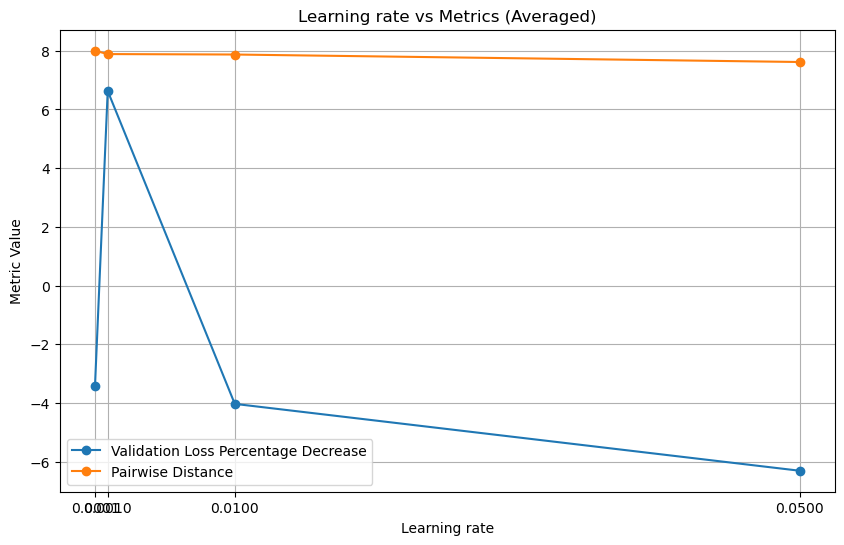

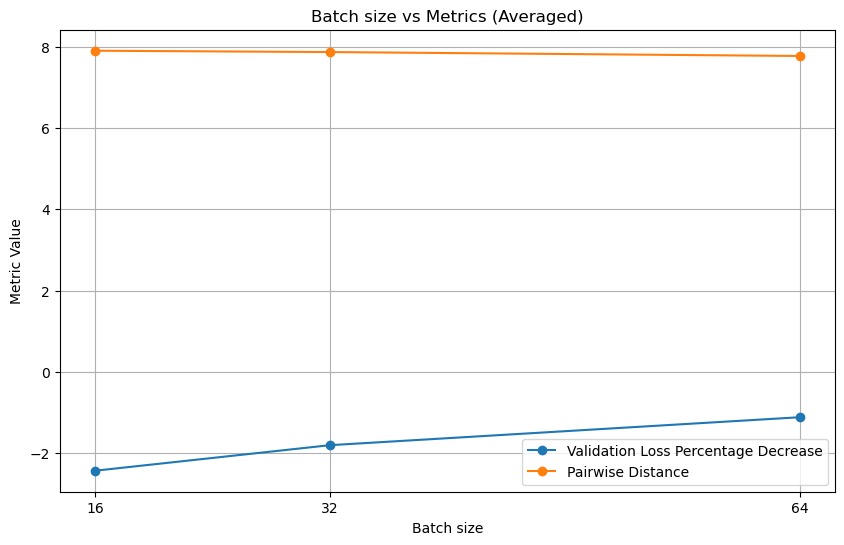

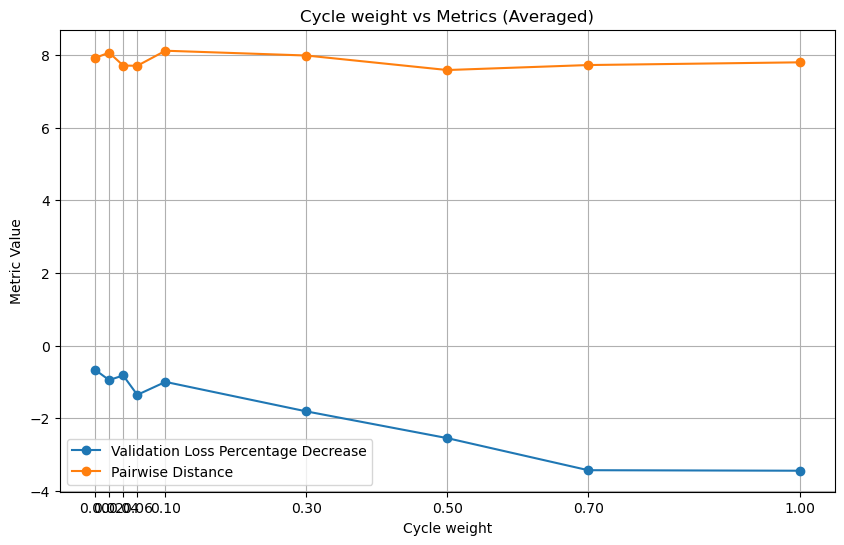

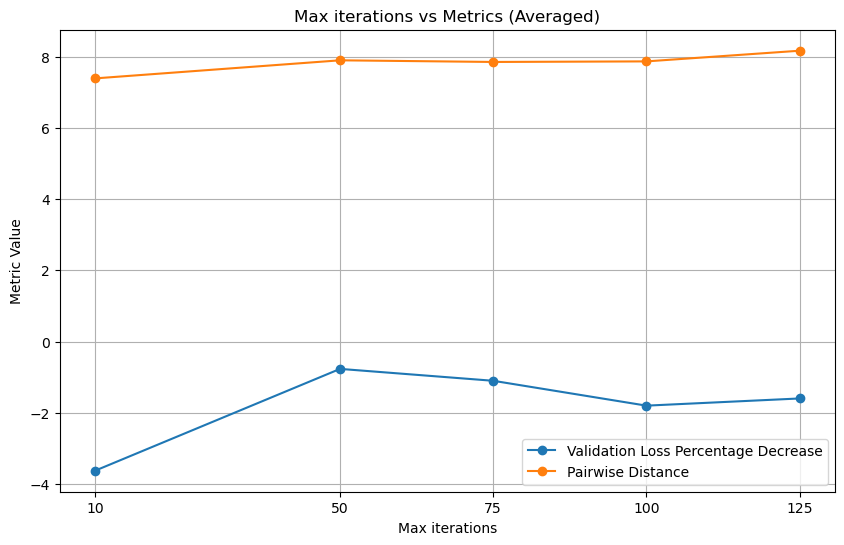

In [42]:
# Define the hyperparameter search space
hyperparameter_space = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.05],
    "batch_size": [16, 32, 64],
    "cycle_weight": [0.0, 0.1, 0.02, 0.3, 0.04, 0.5, 0.06, 0.7, 1],
    "max_iterations": [10, 50, 75, 100, 125]
}

params = Parameter(
    sound_path="./corpora/sound/TinySOL",
    text_path="./corpora/text/longer.txt",
    sound_encoder="MuQ",
    text_encoder="fastText",
    sound_preprocessing='full',  # in ms
    dim=5,
    mapping='icp',
    distance_metric="euclidean",
    trim_silence=True,
    normalization="standard"
)

s_emb, t_emb = load_and_process(params)
r = tune_icp_parameters(s_emb, t_emb, hyperparameter_space) 
generate_plots(r)

In [2]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import the get_onsets function from your main.py file
from main import get_onsets, SAMPLING_RATE

# Load a sound file
def load_sound_file(file_path):
    """
    Load a sound file using librosa.
    Args:
        file_path (str): Path to the sound file.
    Returns:
        np.ndarray: Audio time series.
        int: Sampling rate of the audio.
    """
    y, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    return y, sr

# Display playback elements for the first N onsets
def display_onset_playback(onsets, sr, N=5):
    """
    Display playback elements for the first N onsets.
    Args:
        onsets (list of np.ndarray): List of audio segments (onsets).
        sr (int): Sampling rate of the audio.
        N (int): Number of onsets to display.
    """
    for i, onset in enumerate(onsets[:N]):
        print(f"Onset {i + 1}:")
        ipd.display(ipd.Audio(onset, rate=sr))

# Main script
sound_file_path = Path("corpora\sound\choir\Aftonen_Soprano 1_Arlyss Hays.m4a")  # Replace with the path to your sound file
# sound_file_path = Path("corpora\sound\\targets\A_minor.wav")  # Replace with the path to your sound file

if not sound_file_path.exists():
    raise FileNotFoundError(f"Sound file not found: {sound_file_path}")

# Load the sound file
print("Loading sound file...")
y, sr = load_sound_file(sound_file_path)

# Use the get_onsets function to separate the sound into onsets
print("Detecting onsets...")
onsets = get_onsets(y)

# Display the number of onsets detected
print(f"Number of onsets detected: {len(onsets)}")

# Display playback elements for the first N onsets
N = 20  # Number of onsets to display
print(f"Displaying playback for the first {N} onsets:")
display_onset_playback(onsets, sr, N=N)

Loading sound file...


C:\Users\dzluk\AppData\Local\Temp\ipykernel_21796\173810026.py:21: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SAMPLING_RATE)
c:\Users\dzluk\.conda\envs\QE\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Detecting onsets...
Number of onsets detected: 333
Displaying playback for the first 20 onsets:
Onset 1:


Onset 2:


Onset 3:


Onset 4:


Onset 5:


Onset 6:


Onset 7:


Onset 8:


Onset 9:


Onset 10:


Onset 11:


Onset 12:


Onset 13:


Onset 14:


Onset 15:


Onset 16:


Onset 17:


Onset 18:


Onset 19:


Onset 20:
